# Projet CENSE

In [141]:
import os
import numpy as np 
import numpy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from glob import glob
import librosa as lr

from sklearn.decomposition import PCA

On s'intéresse ici à plusieurs manière de mesurer la distance entre deux échantillons audios. On voudrait ainsi classifier les audios à l'aide de ces distances.

## 1. Préprocessing

On commence par une petite phase de prétraitement sur les données.

Les données sont les matrices de MFCC des échantillons stockées dans la liste data. Elles sont regroupés par classes, c'est-à-dire que les 10 premiers éléments sont de la classe "bus", les 10 suivants de la classe "busytreet" et ainsi de suite. La liste labels contient les labels correspondant aux données et le dictionnaire dict_label est le dictionnaire faisant correspondre le numéro d'un label à son nom.

In [5]:
#set directory for source files 
data_dir = './scenes_stereo/'

audio_files = glob(data_dir + '*.wav')
print('file size:',len(audio_files))

file size: 100


In [7]:
data_list = glob(data_dir+"/*")
data = [] # Contiendra les mfcc de chaque échantillon

for name in ['bus','busystreet','office','openairmarket','park','quietstreet','restaurant','supermarket','tube','tubestation']:
    for k in range(1,10):
        data.append(lr.feature.mfcc(lr.load(data_dir+name + '0'+str(k)+'.wav')[0],n_mfcc = 40))
    data.append(lr.feature.mfcc(lr.load(data_dir+name + '10'+'.wav')[0],n_mfcc = 40))
    


In [8]:
labels = [] # Labels des échantillons
for k in range(10):
    labels = labels+[k]*10
    
dict_labels = {'bus':0,'busystreet':1,'office':2,'openairmarket':3,'park':4,'quietstreet':5,'restaurant':6,'supermarket':7,'tube':8,'tubestation':9} 

## 2. Dynamique des MFCC

On trace les coefficients de quelques échantillons.

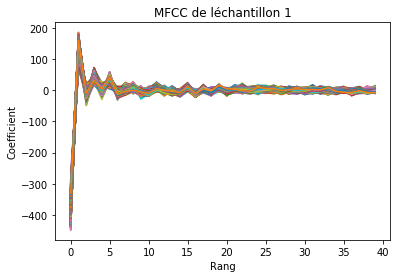

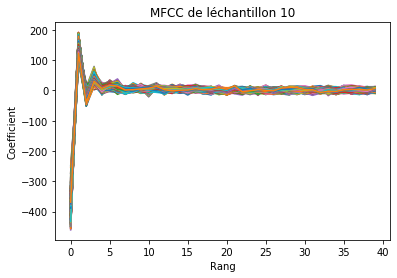

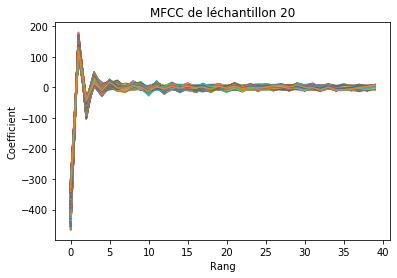

In [42]:
plt.plot((data[0]))
plt.ylabel('Coefficient')
plt.xlabel('Rang')
plt.title('MFCC de l''échantillon 1')
plt.show()

plt.plot((data[9]))
plt.ylabel('Coefficient')
plt.xlabel('Rang')
plt.title('MFCC de l''échantillon 10')
plt.show()

plt.plot((data[19]))
plt.ylabel('Coefficient')
plt.xlabel('Rang')
plt.title('MFCC de l''échantillon 20')
plt.show()


On constate une décroissance en valeur absolue des coefficients. Par ailleurs, le premiers coefficient et bien plus gros (en valeur absolue) que les autres. 

On va essayer nos mesures de similarités sur plusieurs choses :
* Les MFCC normalisés par le premier coefficients
* Les MFCC normalisés centrés-réduits
* Les MFCC sans le premier coefficient
    * Divisés par le premier coefficient restant
    * Centrés-réduits

In [222]:
# Construction des différents 

data_norm = []
data_norm_cr = []
for k in range(len(data)):
    data_norm.append(data[k]/data[k][0,:])
    data_norm_cr.append((data_norm[k]-np.mean(data_norm[k],axis=0))/np.std(data_norm[k],axis=0))


In [240]:
# Même chose en ôtant le premier coefficient

data2 = []
data2_norm = []
data2_norm_cr = []
for k in range(len(data)):
    data2.append(data[k][1:40,:])
    data2_norm.append(data2[k]/data2[k][0,:])
    data2_norm_cr.append((data2_norm[k]-np.mean(data2_norm[k],axis=0))/np.std(data2_norm[k],axis=0))
    
print(np.shape(data))
print(np.shape(data2))

(100, 40, 1292)
(100, 39, 1292)


## 3. Distance moyennée


On s'intéresse ici à une manière de calculer la distance entres matrices MFCC. Il s'agit ici, pour deux matrices $M$ et $N$, de retenir la distance euclidienne entre les vecteurs $\overline{M}$ et $\overline{N}$ qui correspondent respectivement aux vecteurs contenant les moyennes de chaque trame (\textit{i.e.} chaque ligne} de $M$ et de $N$.

D'un point de vu qualitatif, le moyennage fait perdre l'information temporel sur les événements. On sait si un événement arrive, mais pas à quel moment, ce qui, de toute manière, importe peu.

On teste dans un premier temps avec la distance euclidienne puis avec a distance cosinus.

In [225]:
def dist(x,y,choix):
    if choix == "euclidian":
        return(np.linalg.norm(x-y))
    elif choix=="cosine":
        return(1-np.vdot(x,y)/np.linalg.norm(x)/np.linalg.norm(y))

In [253]:
def dist_moy(x,y,choix):
    """x et y sont des matrices de MFCC. On calcule la distance entre x et y en faisant la 
    moyenne de chaque dans les matrices puis on regarde la distance entre les deux vecteurs de moyennes."""
    
    xbarre = np.mean(x,axis=1)
    ybarre = np.mean(y,axis=1)
    
    return(dist(xbarre,ybarre,choix))

In [254]:
# Construction des matrices des distances pour la distance euclidienne

mat_dist_moy_norm = np.zeros((100,100))
mat_dist_moy_cr = np.zeros((100,100))

mat_dist_moy_norm2 = np.zeros((100,100))
mat_dist_moy_cr2 = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_moy_norm[i,j] = dist_moy(data_norm[i],data_norm[j],'euclidian')
        mat_dist_moy_norm[j,i] = mat_dist_moy_norm[i,j]
        
        mat_dist_moy_cr[i,j] = dist_moy(data_norm_cr[i],data_norm_cr[j],'euclidian')
        mat_dist_moy_cr[j,i] = mat_dist_moy_cr[i,j]
        
        mat_dist_moy_norm2[i,j] = dist_moy(data2_norm[i],data2_norm[j],'euclidian')
        mat_dist_moy_norm2[j,i] = mat_dist_moy_norm2[i,j]
        
        mat_dist_moy_cr2[i,j] = dist_moy(data2_norm_cr[i],data2_norm_cr[j],'euclidian')
        mat_dist_moy_cr2[j,i] = mat_dist_moy_cr2[i,j]

Pour évaluer la performance de ces distances, on regarde la précision à 5.

In [255]:
def p_at_k(mat_dist,k=5,labels=labels):
    p5 = np.zeros(100)
    for k in range(100):
        dist = mat_dist[k,:]
        distsort = np.argsort(np.ravel(dist))

        p5[k] = np.sum([labels[distsort[i]]==labels[k] for i in range(1,6)])/5
    return(np.mean(p5))

In [241]:
print('p@5 MFCC normalisés : ',p_at_k(mat_dist_moy_norm))
print('p@5 MFCC centrés-réduits : ',p_at_k(mat_dist_moy_cr))

print('p@5 MFCC normalisés sans premier coeff : ',p_at_k(mat_dist_moy_norm))
print('p@5 MFCC centrés-réduits sans premier coeff : ',p_at_k(mat_dist_moy_cr))

p@5 MFCC normalisés :  0.33399999999999996
p@5 MFCC centrés-réduits :  0.32
p@5 MFCC normalisés sans premier coeff :  0.33399999999999996
p@5 MFCC centrés-réduits sans premier coeff :  0.32


In [256]:
# Construction des matrices des distances pour la distance cosinus

mat_dist_moy_norm = np.zeros((100,100))
mat_dist_moy_cr = np.zeros((100,100))

mat_dist_moy_norm2 = np.zeros((100,100))
mat_dist_moy_cr2 = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_moy_norm[i,j] = dist_moy(data_norm[i],data_norm[j],'cosine')
        mat_dist_moy_norm[j,i] = mat_dist_moy_norm[i,j]
        
        mat_dist_moy_cr[i,j] = dist_moy(data_norm_cr[i],data_norm_cr[j],'cosine')
        mat_dist_moy_cr[j,i] = mat_dist_moy_cr[i,j]
        
        mat_dist_moy_norm2[i,j] = dist_moy(data2_norm[i],data2_norm[j],'cosine')
        mat_dist_moy_norm2[j,i] = mat_dist_moy_norm2[i,j]
        
        mat_dist_moy_cr2[i,j] = dist_moy(data2_norm_cr[i],data2_norm_cr[j],'cosine')
        mat_dist_moy_cr2[j,i] = mat_dist_moy_cr2[i,j]

In [257]:
print('p@5 MFCC normalisés : ',p_at_k(mat_dist_moy_norm))
print('p@5 MFCC centrés-réduits : ',p_at_k(mat_dist_moy_cr))

print('p@5 MFCC normalisés sans premier coeff : ',p_at_k(mat_dist_moy_norm))
print('p@5 MFCC centrés-réduits sans premier coeff : ',p_at_k(mat_dist_moy_cr))

p@5 MFCC normalisés :  0.3660000000000001
p@5 MFCC centrés-réduits :  0.3360000000000001
p@5 MFCC normalisés sans premier coeff :  0.3660000000000001
p@5 MFCC centrés-réduits sans premier coeff :  0.3360000000000001


Dans tous les cas, les résultats sont peu satisfaisants. On essaie avec une distance "trame à trame".

## 4. Distance trame à trame

Ici, la distance entre $M$ et $N$ est calculée en retenant la distance euclidienne entre les deux trames les plus proches de ces deux matrices de MFCC.

Là encore, on teste dans un premier temps avec la distance euclidienne puis avec la distance cosinus.

In [251]:
def dist_trame(x,y,choix):
    """La distance entre x et y correspond à la distance entre les deux trames les plus proches."""
    n,m = np.shape(x)
    distxy = np.zeros((m,1))
    for k in range(m):
        distxy[k] = dist(x[:,k],y[:,k],choix)
    return(distxy[np.where(distxy==min(distxy))[0][0]])


In [258]:
# Construction des matrices des distances pour la distance euclidienne

mat_dist_trame_norm = np.zeros((100,100))
mat_dist_trame_cr = np.zeros((100,100))

mat_dist_trame_norm2 = np.zeros((100,100))
mat_dist_trame_cr2 = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_trame_norm[i,j] = dist_trame(data_norm[i],data_norm[j],'euclidian')
        mat_dist_trame_norm[j,i] = mat_dist_trame_norm[i,j]
        
        mat_dist_trame_cr[i,j] = dist_trame(data_norm_cr[i],data_norm_cr[j],'euclidian')
        mat_dist_trame_cr[j,i] = mat_dist_trame_cr[i,j]
        
        mat_dist_trame_norm2[i,j] = dist_trame(data2_norm[i],data2_norm[j],'euclidian')
        mat_dist_trame_norm2[j,i] = mat_dist_trame_norm2[i,j]
        
        mat_dist_trame_cr2[i,j] = dist_trame(data2_norm_cr[i],data2_norm_cr[j],'euclidian')
        mat_dist_trame_cr2[j,i] = mat_dist_trame_cr2[i,j]

In [259]:
print('p@5 MFCC normalisés : ',p_at_k(mat_dist_trame_norm))
print('p@5 MFCC centrés-réduits : ',p_at_k(mat_dist_trame_cr))

print('p@5 MFCC normalisés sans premier coeff : ',p_at_k(mat_dist_trame_norm))
print('p@5 MFCC centrés-réduits sans premier coeff : ',p_at_k(mat_dist_trame_cr))

p@5 MFCC normalisés :  0.28400000000000003
p@5 MFCC centrés-réduits :  0.278
p@5 MFCC normalisés sans premier coeff :  0.28400000000000003
p@5 MFCC centrés-réduits sans premier coeff :  0.278


In [260]:
# Construction des matrices des distances pour la distance cosinus

mat_dist_trame_norm = np.zeros((100,100))
mat_dist_trame_cr = np.zeros((100,100))

mat_dist_trame_norm2 = np.zeros((100,100))
mat_dist_trame_cr2 = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_trame_norm[i,j] = dist_trame(data_norm[i],data_norm[j],'cosine')
        mat_dist_trame_norm[j,i] = mat_dist_trame_norm[i,j]
        
        mat_dist_trame_cr[i,j] = dist_trame(data_norm_cr[i],data_norm_cr[j],'cosine')
        mat_dist_trame_cr[j,i] = mat_dist_trame_cr[i,j]
        
        mat_dist_trame_norm2[i,j] = dist_trame(data2_norm[i],data2_norm[j],'cosine')
        mat_dist_trame_norm2[j,i] = mat_dist_trame_norm2[i,j]
        
        mat_dist_trame_cr2[i,j] = dist_trame(data2_norm_cr[i],data2_norm_cr[j],'cosine')
        mat_dist_trame_cr2[j,i] = mat_dist_trame_cr2[i,j]

In [261]:
print('p@5 MFCC normalisés : ',p_at_k(mat_dist_trame_norm))
print('p@5 MFCC centrés-réduits : ',p_at_k(mat_dist_trame_cr))

print('p@5 MFCC normalisés sans premier coeff : ',p_at_k(mat_dist_trame_norm))
print('p@5 MFCC centrés-réduits sans premier coeff : ',p_at_k(mat_dist_trame_cr))

p@5 MFCC normalisés :  0.29400000000000004
p@5 MFCC centrés-réduits :  0.278
p@5 MFCC normalisés sans premier coeff :  0.29400000000000004
p@5 MFCC centrés-réduits sans premier coeff :  0.278


Là encore, les scores sont faibles.